In [54]:
# imports

import torch
import pandas as pd
import matplotlib.pyplot as plt

from utils import ProjectFolders

In [55]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Load the dataset
df_final = pd.read_csv(ProjectFolders.FINAL_DATASET_FILE)

# Define labels and features
DECILE_LABEL = 'decile_score'
TWO_YEAR_REC_LABEL = 'two_year_recid'

# Scale the decile score to [0, 1] and extract labels and features
y = df_final[DECILE_LABEL].values / 10  # Normalize decile score
y_two_year_recid = df_final[TWO_YEAR_REC_LABEL].values  # Binary label
X = df_final.drop(columns=[DECILE_LABEL, TWO_YEAR_REC_LABEL]).values  # Features

# First, split into train+validation and test datasets
X_train_val, X_test, y_train_val, y_test, y_two_year_recid_train_val, y_two_year_recid_test = train_test_split(
    X, y, y_two_year_recid, test_size=0.2, random_state=42
)

# Then, split train+validation into train and validation datasets
X_train, X_val, y_train, y_val, y_two_year_recid_train, y_two_year_recid_val = train_test_split(
    X_train_val, y_train_val, y_two_year_recid_train_val, test_size=0.25, random_state=42
)
# Note: 0.25 of the train+validation set = 0.2 of the total dataset, resulting in 60/20/20 split
# Convert datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Convert the binary labels (two_year_recid) to tensors
y_two_year_recid_train_tensor = torch.tensor(y_two_year_recid_train, dtype=torch.float32)
y_two_year_recid_val_tensor = torch.tensor(y_two_year_recid_val, dtype=torch.float32)
y_two_year_recid_test_tensor = torch.tensor(y_two_year_recid_test, dtype=torch.float32)

# Print dataset sizes for verification
print(f"Train set: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Validation set: {X_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test set: {X_test_tensor.shape}, {y_test_tensor.shape}")


Train set: torch.Size([4328, 16]), torch.Size([4328])
Validation set: torch.Size([1443, 16]), torch.Size([1443])
Test set: torch.Size([1443, 16]), torch.Size([1443])


In [56]:
from utils import compare_score


compare_score(y_train_tensor, y_two_year_recid_train_tensor)




TN: 1795
FP: 540
FN: 941
TP: 1052
Senstivity: 0.5278474661314602
Specificity: 0.7687366167023555
Precision: 0.6608040201005025
Accuracy: 0.6578096118299446


In [57]:
df_final.drop(columns=[DECILE_LABEL, TWO_YEAR_REC_LABEL]).describe()

,priors_count,juv_fel_count,juv_misd_count,juv_other_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M,c_charge_degree_F,age_cat_Greater than 45,age_cat_Less than 25
count,7.214000e+03,7.214000e+03,7.214000e+03,7.214000e+03,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,4.432274e-17,7.904222e-17,4.136789e-17,3.545819e-17,0.193374,0.806626,0.512337,0.004436,0.340172,0.088301,0.002495,0.052259,0.353202,0.646798,0.218464,0.211949
std,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,0.394971,0.394971,0.499882,0.066459,0.473800,0.283751,0.049893,0.222565,0.477998,0.477998,0.413233,0.408717
min,-7.112398e-01,-1.418546e-01,-1.874142e-01,-2.180649e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.112398e-01,-1.418546e-01,-1.874142e-01,-2.180649e-01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.015884e-01,-1.418546e-01,-1.874142e-01,-2.180649e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.128887e-01,-1.418546e-01,-1.874142e-01,-2.180649e-01,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,7.072137e+00,4.205770e+01,2.660539e+01,3.367679e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


3201
Epoch [1/5000], Training loss: 0.1019 Validation Loss: 0.08637364208698273, validation_delta: 0
Epoch [2/5000], Training loss: 0.0858 Validation Loss: 0.07839876413345337, validation_delta: 0.007974877953529358
Epoch [3/5000], Training loss: 0.0795 Validation Loss: 0.07519558817148209, validation_delta: 0.003203175961971283
Epoch [4/5000], Training loss: 0.0764 Validation Loss: 0.07338705658912659, validation_delta: 0.0018085315823554993
Epoch [5/5000], Training loss: 0.0743 Validation Loss: 0.07199183106422424, validation_delta: 0.0013952255249023438
Epoch [6/5000], Training loss: 0.0726 Validation Loss: 0.07075773924589157, validation_delta: 0.0012340918183326721
Epoch [7/5000], Training loss: 0.0711 Validation Loss: 0.06962209194898605, validation_delta: 0.0011356472969055176
Epoch [8/5000], Training loss: 0.0698 Validation Loss: 0.0685674250125885, validation_delta: 0.0010546669363975525
Epoch [9/5000], Training loss: 0.0685 Validation Loss: 0.0675816759467125, validation_delt

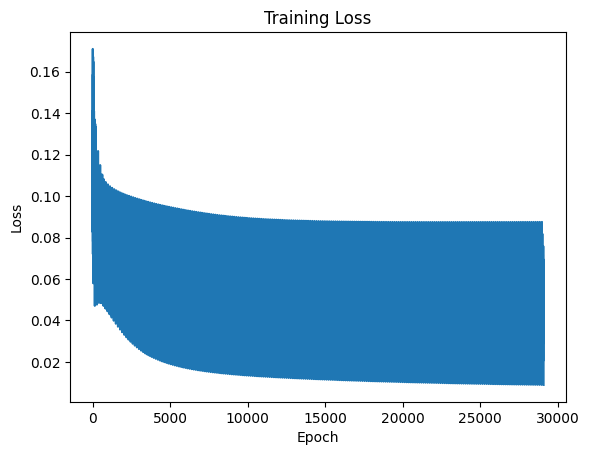

Text(0.5, 1.0, 'Validation Loss')

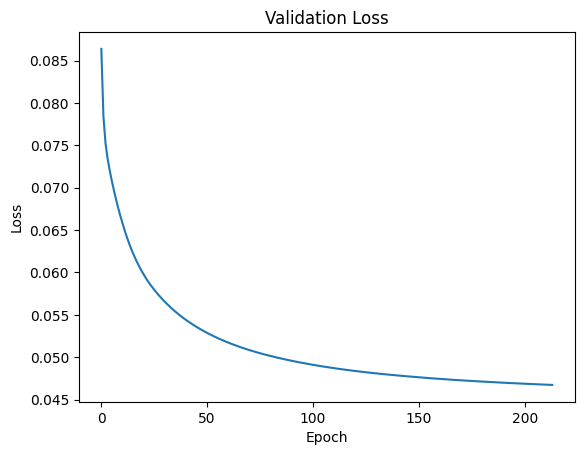

In [59]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Define the model       
layers = [
    nn.Linear(16, 64),  nn.ReLU(),
    # nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
    # nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
    # nn.Linear(64, 64), nn.BatchNorm1d(64), nn.ReLU(),
    # nn.Linear(64, 64),  nn.ReLU(),
    nn.Linear(64, 32),  nn.ReLU(),
    nn.Linear(32, 1),
]

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


EPOCHS = 5000
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EARLY_STOPPING_THRESHOLD = 1e-5

training_samples = X_train_tensor.size(0)
batches_per_epoch = training_samples / BATCH_SIZE

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    training_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, training_samples, BATCH_SIZE):
        # Mini-batch preparation
        X_batch = X_train_tensor[i:i+BATCH_SIZE]
        y_batch = y_train_tensor[i:i+BATCH_SIZE]

        # Forward pass
        x = X_batch
        for layer in layers:
            x = layer(x)
        
        # Loss calculation
        loss = F.mse_loss(x.squeeze(), y_batch)
        
        # Clear gradients (ensure no accumulation of gradients)
        for p in parameters:
            if p.grad is not None:
                p.grad.zero_()

        # Backward pass
        loss.backward()
        for p in parameters:
            p.data -= LEARNING_RATE * p.grad

        # Track epoch loss
        training_loss += loss.item()
        training_losses.append(loss.item())     
    
    
    validation_loss_delta = 1
    
    # # Validation loss
    with torch.no_grad():
        # Validation loss
        x = X_val_tensor
        for layer in layers:
            x = layer(x)
        val_loss = F.mse_loss(x.squeeze(), y_val_tensor)
        validation_losses.append(val_loss.item())
        validation_loss_delta = abs(validation_losses[-1] - validation_losses[-2]) if len(validation_losses) > 1 else 0
    
    # Early stopping
    if epoch > 5 and  validation_loss_delta < EARLY_STOPPING_THRESHOLD:
        print(f"Early stopping at epoch {epoch+1}, {validation_losses[-1]}, {validation_losses[-2]}")
        break
    
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Training loss: {training_loss/batches_per_epoch:.4f}", f"Validation Loss: {val_loss}, validation_delta: {validation_loss_delta}")

plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(validation_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')



In [ ]:
import numpy as np
from utils import compare_score

# Perform predictions on the validation dataset
with torch.no_grad():
    x = X_val_tensor
    for layer in layers:
        x = layer(x)

predictions_val = x.squeeze()

print(f'Loss: {F.mse_loss(predictions_val, y_val_tensor)}')

compare_score(predictions_val, y_two_year_recid_val_tensor)


# perform predictions on the test dataset
with torch.no_grad():
    x = X_test_tensor
    for layer in layers:
        x = layer(x)

predictions_test = x.squeeze()

print(f'Loss: {F.mse_loss(predictions_test, y_test_tensor)}')

compare_score(predictions_test, y_two_year_recid_test_tensor)




Loss: 0.04646167531609535
TN: 606
FP: 199
FN: 286
TP: 352
Senstivity: 0.5517241379310345
Specificity: 0.7527950310559006
Precision: 0.6388384754990926
Accuracy: 0.6638946638946639
Loss: 0.04913723096251488
TN: 624
FP: 199
FN: 254
TP: 366
Senstivity: 0.5903225806451613
Specificity: 0.7582017010935601
Precision: 0.647787610619469
Accuracy: 0.6860706860706861
